Week 1  : Data Preparation


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Mounted at /content/drive
--- Starting Milestone 1, Week 1: Data Collection & Labeling ---

Scanning for Authentic scanner images...


9it [00:00, 339.82it/s]



Scanning for Tampered images...


100%|██████████| 236/236 [00:00<00:00, 290791.93it/s]



Scanning and converting Original documents...


100%|██████████| 238/238 [03:00<00:00,  1.32it/s]



Scan complete. Created 'final_master_dataset.csv' with 1204 total images.

Final class distribution:
label
Original       238
Tampered       236
EpsonV370-1    145
HP             142
EpsonV550      132
EpsonV39-1     112
Canon9000-1     95
Canon120-1      73
Canon220        31
Name: count, dtype: int64


--- Analyzing a sample image ---
Analyzing: /content/drive/MyDrive/SUPERLANTIQUE_FOLDER/SUPATLANTIQUE/Flatfield/Flatfield/Canon220/300.tif
Resolution: 2480 x 3508
Number of Channels: 3


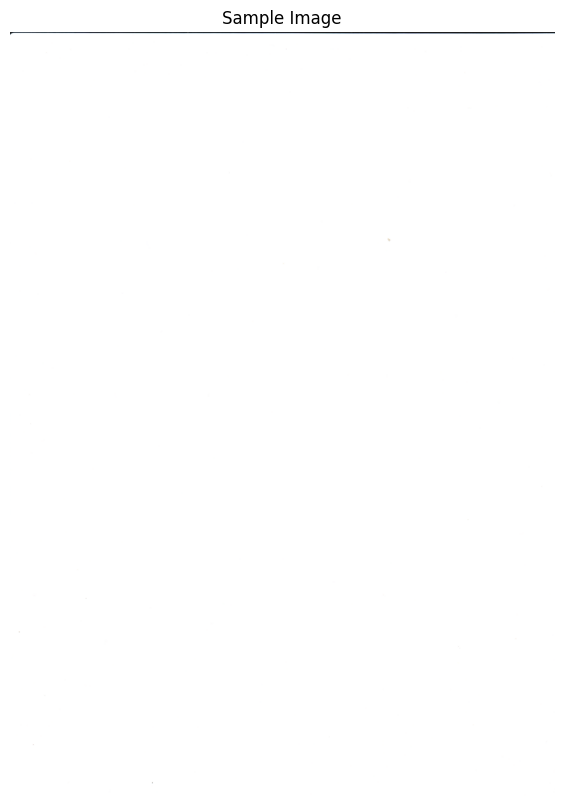


--- Week 1 Complete ---


In [ ]:
# First, install the necessary libraries for PDF conversion
!pip install pdf2image
!apt-get install -y poppler-utils

import pandas as pd
import os
from google.colab import drive
from tqdm import tqdm
from pdf2image import convert_from_path
import cv2
import matplotlib.pyplot as plt

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION (Based on your final folder structure) ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"

# Paths to your three final, clean data folders
AUTHENTIC_SCANS_PATH = os.path.join(PROJECT_PATH, "SUPATLANTIQUE", "Flatfield")
TAMPERED_IMAGES_PATH = os.path.join(PROJECT_PATH, "Tamperedimg")
ORIGINAL_PDF_PATH = os.path.join(PROJECT_PATH, "originalimg")

# Path to save the images converted from your PDFs
CONVERTED_PDF_PATH = os.path.join(PROJECT_PATH, "PDF_CONVERTED_IMAGES")
os.makedirs(CONVERTED_PDF_PATH, exist_ok=True)
# ==================================================================================

print("--- Starting Milestone 1, Week 1: Data Collection & Labeling ---")

file_paths = []
labels = []

# --- 1. Process AUTHENTIC Scanner Images ---
print("\nScanning for Authentic scanner images...")
for dirpath, dirnames, filenames in tqdm(os.walk(AUTHENTIC_SCANS_PATH)):
    label = os.path.basename(dirpath)
    if label != "Flatfield": # Ensure we are in a scanner subfolder (e.g., HP, Canon120-1)
        for filename in filenames:
            if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg')):
                file_paths.append(os.path.join(dirpath, filename))
                labels.append(label)

# --- 2. Process TAMPERED Images ---
print("\nScanning for Tampered images...")
for filename in tqdm(os.listdir(TAMPERED_IMAGES_PATH)):
    if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg')):
        file_paths.append(os.path.join(TAMPERED_IMAGES_PATH, filename))
        labels.append("Tampered")

# --- 3. Process ORIGINAL PDF & Image Files ---
print("\nScanning and converting Original documents...")
for filename in tqdm(os.listdir(ORIGINAL_PDF_PATH)):
    file_path_full = os.path.join(ORIGINAL_PDF_PATH, filename)

    # Handle direct images in the 'originalimg' folder
    if filename.lower().endswith(('.tif', '.tiff', '.png', '.jpg')):
        file_paths.append(file_path_full)
        labels.append("Original")

    # Handle PDFs in the 'originalimg' folder
    elif filename.lower().endswith('.pdf'):
        try:
            pages = convert_from_path(file_path_full, 300)
            for i, page in enumerate(pages):
                new_image_name = f"{os.path.splitext(filename)[0]}_page_{i+1}.png"
                new_image_path = os.path.join(CONVERTED_PDF_PATH, new_image_name)
                page.save(new_image_path, 'PNG')
                file_paths.append(new_image_path)
                labels.append("Original")
        except Exception as e:
            print(f"\nCould not process PDF {file_path_full}. Error: {e}")

# Create and save the final DataFrame
df = pd.DataFrame({'file_path': file_paths, 'label': labels})
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df.to_csv(csv_path, index=False)

print(f"\nScan complete. Created 'final_master_dataset.csv' with {len(df)} total images.")
print("\nFinal class distribution:")
print(df['label'].value_counts())

# --- Analyze a sample image ---
if not df.empty:
    print("\n\n--- Analyzing a sample image ---")
    sample_path = df['file_path'].iloc[0]
    print(f"Analyzing: {sample_path}")

    try:
        sample_image = cv2.imread(sample_path)
        if sample_image is not None:
            height, width, channels = sample_image.shape
            print(f"Resolution: {width} x {height}")
            print(f"Number of Channels: {channels}")

            plt.figure(figsize=(8, 10))
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title("Sample Image")
            plt.axis('off')
            plt.show()
        else:
            print(f"Could not read the sample image at path: {sample_path}")
    except Exception as e:
        print(f"An error occurred while analyzing the image: {e}")

print("\n--- Week 1 Complete ---")


Week 2  : Image Processing

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256 # A standard size for feature extraction
# ===================================================================================

print("--- Starting Milestone 1, Week 2: Image Preprocessing ---")

# --- Function Definition ---
def preprocess_image(image_path):
    """Loads an image, converts it to grayscale, resizes, and normalizes it."""
    try:
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image at {image_path}")
            return None

        # Convert to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize the image to our standard size
        img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))

        # Normalize pixel values to be between 0.0 and 1.0
        img_normalized = img_resized / 255.0

        return img_normalized
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# --- Script Execution ---
print("\n--- Testing the preprocessing function ---")

# Load the master CSV file we created in Week 1
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

if not df.empty:
    # Get the path of a sample image from our dataset
    sample_path = df['file_path'].iloc[0]
    print(f"Processing sample image: {sample_path}")

    # Process the image using our new function
    processed_sample = preprocess_image(sample_path)

    if processed_sample is not None:
        print("\nSuccess! Image processed correctly.")
        print(f"Shape after processing: {processed_sample.shape}")
        print(f"Data type after processing: {processed_sample.dtype}")
        print(f"Pixel value range: {processed_sample.min()} to {processed_sample.max()}")
    else:
        print("Failed to process the sample image.")
else:
    print("Dataset CSV is empty. Cannot test preprocessing.")

print("\n--- Week 2 Complete ---")


Mounted at /content/drive
--- Starting Milestone 1, Week 2: Image Preprocessing ---

--- Testing the preprocessing function ---
Processing sample image: /content/drive/MyDrive/SUPERLANTIQUE_FOLDER/SUPATLANTIQUE/Flatfield/Flatfield/Canon220/300.tif

Success! Image processed correctly.
Shape after processing: (256, 256)
Data type after processing: float64
Pixel value range: 0.23529411764705882 to 1.0

--- Week 2 Complete ---


**Milestone 2: Feature Engineering & Baseline Modeling**  


Week 3 :   Extracting the "Fingerprint"

In [ ]:
# First, ensure scikit-image is installed
!pip install scikit-image

import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from skimage.feature import local_binary_pattern

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
# ===================================================================================

print("--- Starting Milestone 2, Week 3: Feature Engineering ---")

# --- Function for Feature Extraction ---
def extract_lbp_features(image_path):
    """Loads an image in grayscale, resizes it, and extracts LBP features."""
    try:
        # Load the image directly as grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None

        # Resize the image
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # LBP works best on integer-type images (0-255 range)
        # Settings: 24 sampling points on a circle of radius 3
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')

        # Calculate the histogram of the LBP patterns. This is our feature vector.
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))

        # Normalize the histogram so it sums to 1
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7) # Add a small value to avoid division by zero

        return hist
    except Exception as e:
        print(f"Error extracting features from {image_path}: {e}")
        return None

# --- Script Execution ---
print("\n--- Testing the feature extraction function ---")

# Load the master CSV file we created in Week 1
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

if not df.empty:
    # Get the path of a sample image
    sample_path = df['file_path'].iloc[0]
    print(f"Extracting LBP features from sample: {sample_path}")

    # Extract features using our new function
    lbp_features = extract_lbp_features(sample_path)

    if lbp_features is not None:
        print("\nSuccess! LBP feature vector extracted.")
        print(f"Length of the feature vector: {len(lbp_features)}")
        print("Here's a preview of the vector (first 10 values):")
        print(lbp_features[:10])
    else:
        print("Failed to extract features from the sample image.")
else:
    print("Dataset CSV is empty. Cannot test feature extraction.")

print("\n--- Week 3 Complete ---")


Mounted at /content/drive
--- Starting Milestone 2, Week 3: Feature Engineering ---

--- Testing the feature extraction function ---
Extracting LBP features from sample: /content/drive/MyDrive/SUPERLANTIQUE_FOLDER/SUPATLANTIQUE/Flatfield/Flatfield/Canon220/300.tif

Success! LBP feature vector extracted.
Length of the feature vector: 26
Here's a preview of the vector (first 10 values):
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.52587891e-05 7.62939453e-05
 1.37329102e-04 2.28881836e-04]

--- Week 3 Complete ---


Week 4: Training the Baseline Model

Mounted at /content/drive
--- Starting Milestone 2, Week 4: Baseline Model Training ---
Loaded 1204 image records from the master dataset.

Extracting LBP features from all images...


100%|██████████| 1204/1204 [52:00<00:00,  2.59s/it]



Successfully processed 1203 images.
Data split into 962 training and 241 testing samples.

Training the Random Forest model...
Evaluating model performance...

--- MODEL RESULTS ---
Baseline Model Accuracy: 83.82%

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.75      0.40      0.52        15
    Canon220       0.60      0.50      0.55         6
 Canon9000-1       0.67      0.84      0.74        19
 EpsonV370-1       0.93      0.97      0.95        29
  EpsonV39-1       0.78      0.82      0.80        22
   EpsonV550       0.90      0.73      0.81        26
          HP       1.00      1.00      1.00        29
    Original       0.85      0.92      0.88        48
    Tampered       0.80      0.83      0.81        47

    accuracy                           0.84       241
   macro avg       0.81      0.78      0.78       241
weighted avg       0.84      0.84      0.83       241


Generating Confusion Matrix...


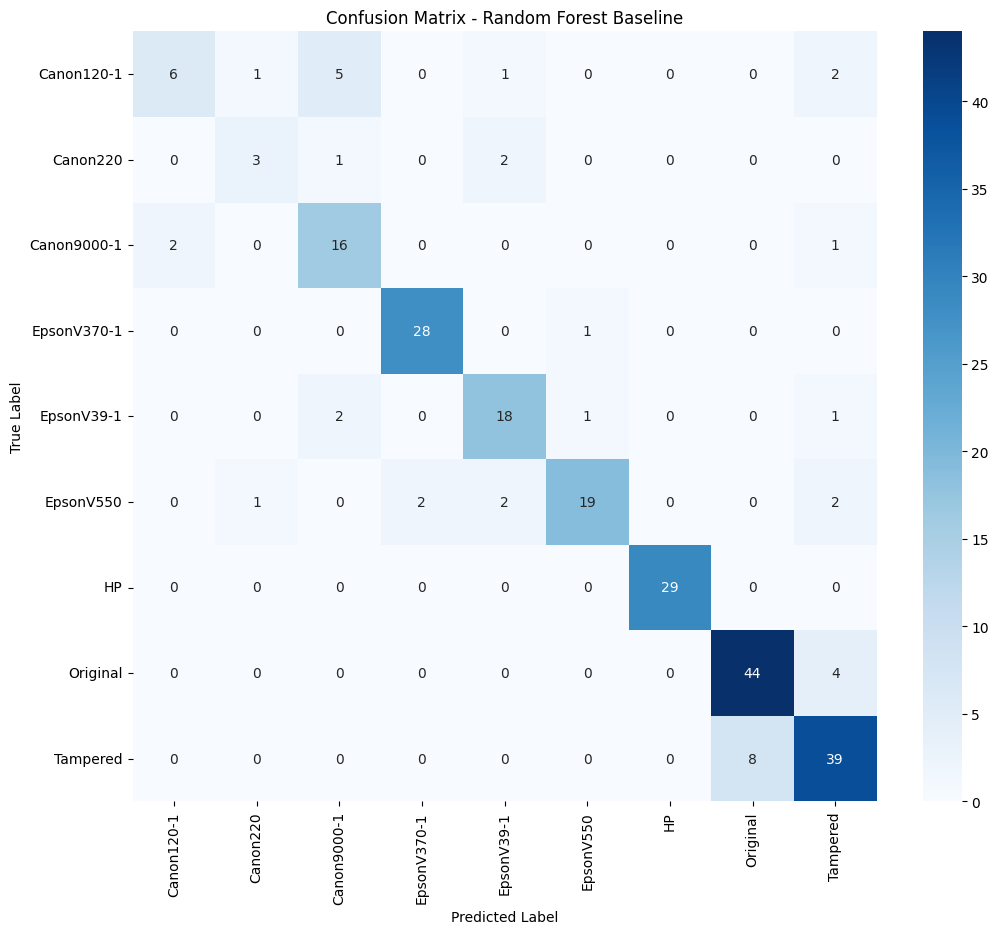


Saving baseline model and label encoder...
Files saved successfully.

--- Week 4 Complete ---


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from skimage.feature import local_binary_pattern
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
# ===================================================================================

print("--- Starting Milestone 2, Week 4: Baseline Model Training ---")

# --- Function from Week 3 ---
def extract_lbp_features(image_path):
    """Loads an image and extracts LBP features without displaying it."""
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception as e:
        return None

# --- Script Execution ---
# 1. Load the dataset CSV
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} image records from the master dataset.")

# 2. Process all images and extract features
print("\nExtracting LBP features from all images...")
features_list = []
labels_list = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

X = np.array(features_list)
y = np.array(labels_list)
print(f"\nSuccessfully processed {len(X)} images.")

# 3. Encode string labels to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Split data into training (80%) and testing (20%) sets
# Using stratify ensures the class distribution is similar in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# 5. Train the Random Forest model
print("\nTraining the Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 6. Evaluate the model on the test data
print("Evaluating model performance...")
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n--- MODEL RESULTS ---")
print(f"Baseline Model Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# 7. Visualize the Confusion Matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest Baseline')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save the model and encoder for later use in the Streamlit app
print("\nSaving baseline model and label encoder...")
joblib.dump(rf_model, os.path.join(PROJECT_PATH, 'baseline_model.joblib'))
joblib.dump(le, os.path.join(PROJECT_PATH, 'baseline_label_encoder.joblib'))
print("Files saved successfully.")

print("\n--- Week 4 Complete ---")


CNN


Mounted at /content/drive
--- Starting Milestone 3, Week 5: Building a Robust CNN ---

Loading and preprocessing images using your established workflow...


100%|██████████| 1204/1204 [33:28<00:00,  1.67s/it]



Successfully loaded and processed 1203 images.
Image array shape: (1203, 128, 128, 3)
Data split into 962 training and 241 testing samples.

Calculating class weights to handle imbalanced data...
Class weights calculated successfully.

Setting up data augmentation...

Building the improved CNN Model using the Functional API...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,290,249 (16.37 MB)

 Trainable params: 4,289,545 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)


Training the CNN Model with Augmented Data and Class Weights...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.3174 - loss: 2.2580 - val_accuracy: 0.1079 - val_loss: 3.4595
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.4976 - loss: 1.5817 - val_accuracy: 0.1120 - val_loss: 3.5649
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6292 - loss: 1.3109 - val_accuracy: 0.1577 - val_loss: 4.8053
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6379 - loss: 1.1588 - val_accuracy: 0.1203 - val_loss: 11.8570
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6675 - loss: 1.1214 - val_accuracy: 0.1203 - val_loss: 23.5355
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7051 - loss: 1.0200 - val_accuracy: 0.1203 - val_loss: 20.4330
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6962 - loss: 1.0831 - val_accuracy: 0.1203 - val_loss: 21.8486
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7113 - loss: 1.0307 - val_accuracy: 0.1743 - val_l


Saving the trained CNN model...
Model and label encoder saved successfully.

Evaluating Final Model...

CNN Model Test Accuracy: 4.56%


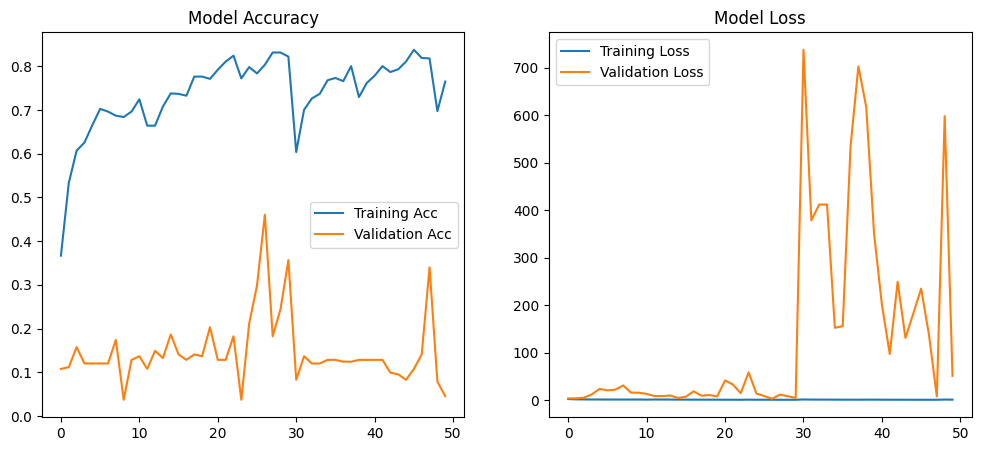


--- Week 5 Complete ---


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt

# Sklearn for preprocessing and class weights
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# TensorFlow / Keras imports, following your style
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
# Let's keep a consistent image size
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50 # We can adjust this later if needed

# ===================================================================================

print("--- Starting Milestone 3, Week 5: Building a Robust CNN ---")

# --- 1. DATA LOADING & PREPROCESSING (Following your method) ---
print("\nLoading and preprocessing images using your established workflow...")
# NOTE: Make sure this is the name of your final CSV file from Week 1
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

images = []
labels = []

# Using your loop to load all images into memory
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # Load image in color, as CNNs can sometimes benefit from color info
        img = cv2.imread(row['file_path'])
        if img is not None:
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img_resized)
            labels.append(row['label'])
    except Exception as e:
        print(f"Skipping file {row['file_path']} due to error: {e}")

# Convert to NumPy arrays and normalize pixel values
X = np.array(images) / 255.0
y = np.array(labels)
print(f"\nSuccessfully loaded and processed {len(X)} images.")
print(f"Image array shape: {X.shape}") # Should be (num_images, 128, 128, 3)

# Encode labels to one-hot vectors
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = len(le.classes_)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.20, random_state=42, stratify=y_categorical
)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# --- 2. ADDRESSING CLASS IMBALANCE (As mentioned in your report) ---
print("\nCalculating class weights to handle imbalanced data...")
# We need the integer-encoded y_train to calculate weights
y_train_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
# Convert to a dictionary for model.fit()
class_weights_dict = dict(enumerate(class_weights))
print("Class weights calculated successfully.")

# --- 3. DATA AUGMENTATION SETUP (Your method) ---
print("\nSetting up data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# --- 4. BUILD THE CNN MODEL (Using Functional API with improvements) ---
print("\nBuilding the improved CNN Model using the Functional API...")
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = BatchNormalization()(x) # Improvement
x = MaxPooling2D((2, 2))(x)

# Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) # Improvement
x = MaxPooling2D((2, 2))(x)

# Block 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x) # Improvement
x = MaxPooling2D((2, 2))(x)

# Classification Head
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x) # Improvement
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- 5. TRAIN THE MODEL ---
print("\nTraining the CNN Model with Augmented Data and Class Weights...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict, # Applying the class weights here
    verbose=1 # Changed to 1 for more detailed progress
)

# --- 6. SAVE THE MODEL ---
print("\nSaving the trained CNN model...")
model.save(os.path.join(PROJECT_PATH, 'cnn_scanner_model_v2.h5'))
# Also save the label encoder, we'll need it for the app
import joblib
joblib.dump(le, os.path.join(PROJECT_PATH, 'cnn_label_encoder.joblib'))
print("Model and label encoder saved successfully.")

# --- 7. EVALUATE AND PLOT RESULTS ---
print("\nEvaluating Final Model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nCNN Model Test Accuracy: {accuracy * 100:.2f}%")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(history.history['accuracy'], label='Training Acc'); plt.plot(history.history['val_accuracy'], label='Validation Acc'); plt.title('Model Accuracy'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history.history['loss'], label='Training Loss'); plt.plot(history.history['val_loss'], label='Validation Loss'); plt.title('Model Loss'); plt.legend()
plt.show()

print("\n--- Week 5 Complete ---")

Week 6 : CNN Evaluation & Explainability

Mounted at /content/drive
--- Starting Milestone 3, Week 6: Evaluation & Explainability ---

Loading the trained model, label encoder, and test data...


Model and label encoder loaded successfully.


Loading images: 100%|██████████| 1204/1204 [36:14<00:00,  1.81s/it]


Test data is ready with 241 samples.

--- Part 1: Detailed Model Evaluation ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.05      0.27      0.08        15
    Canon220       0.03      0.83      0.06         6
 Canon9000-1       0.00      0.00      0.00        19
 EpsonV370-1       0.00      0.00      0.00        29
  EpsonV39-1       0.00      0.00      0.00        22
   EpsonV550       0.00      0.00      0.00        26
          HP       0.00      0.00      0.00        29
    Original       0.00      0.00      0.00        48
    Tampered       1.00      0.04      0.08        47

    accuracy                           0.05       241
   macro avg       0.12      0.13      0.03       241
weighted avg       0.20      0.05      0.02       241


Generating Confusion Matrix...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


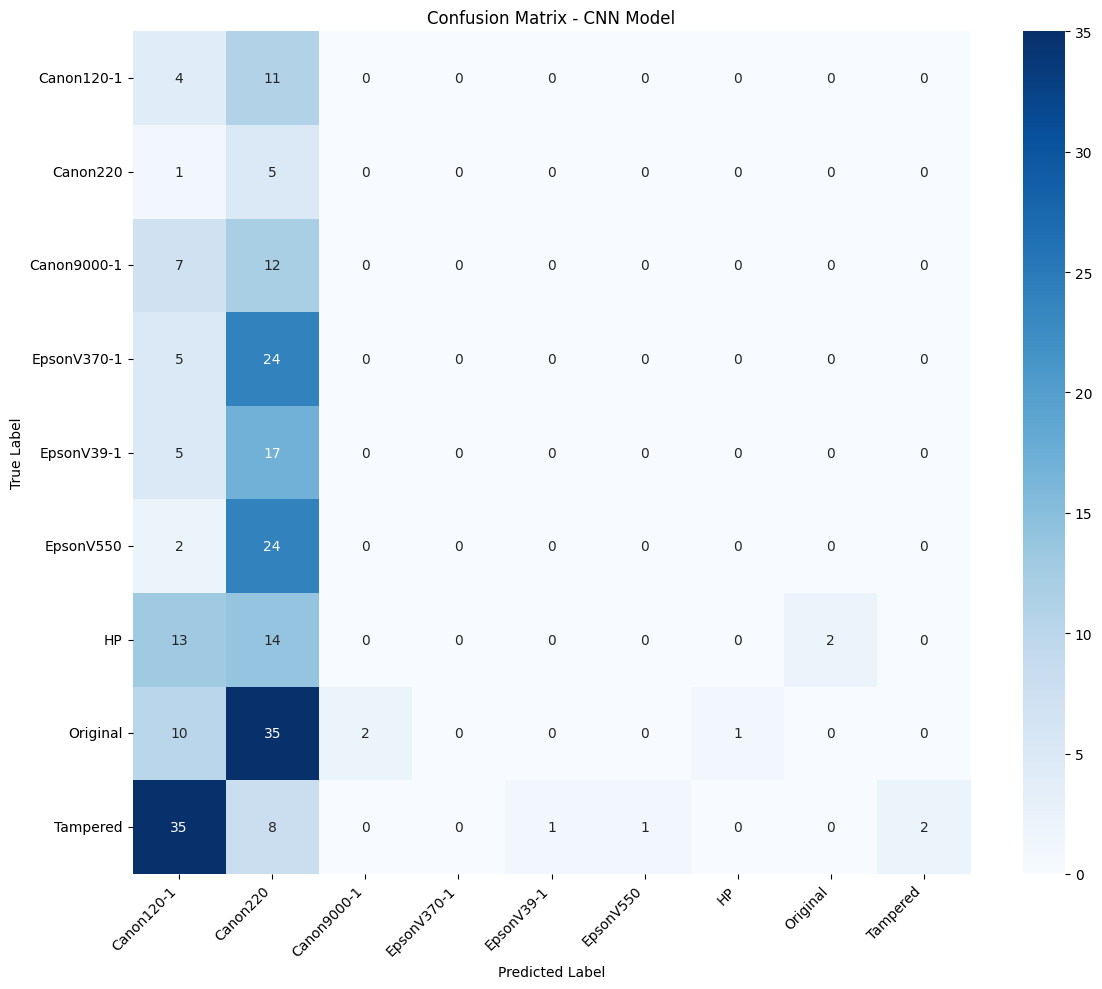


--- Part 2: Model Explainability with Grad-CAM ---
Last convolutional layer found: 'conv2d_8'


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


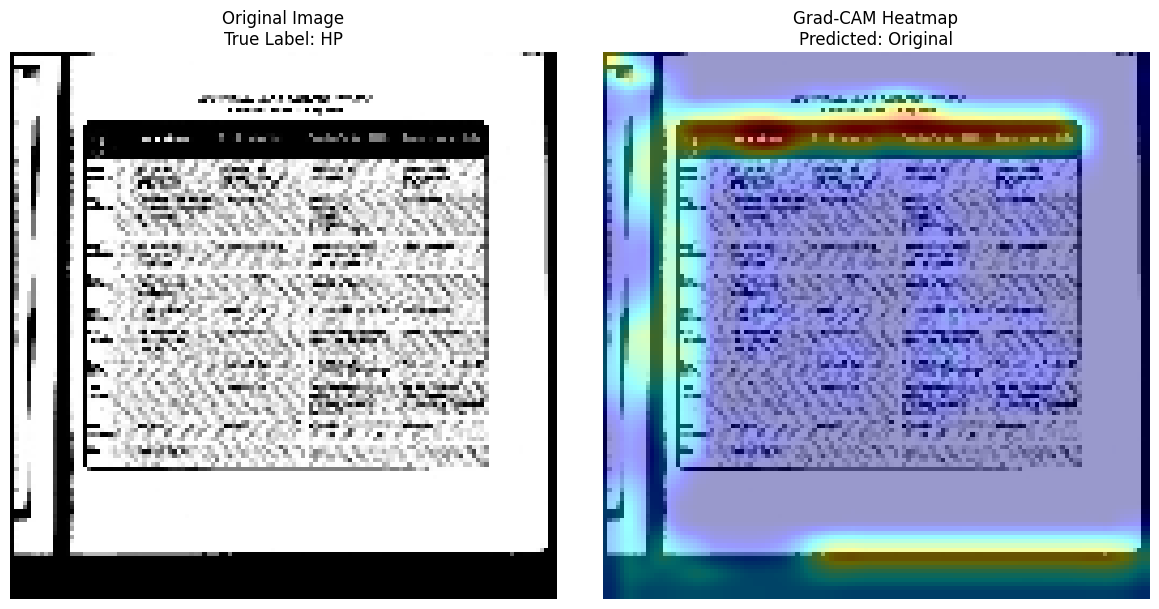


--- Week 6 Complete ---


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import joblib
from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 128

# ===================================================================================

print("--- Starting Milestone 3, Week 6: Evaluation & Explainability ---")

# --- 1. LOAD MODEL AND DATA (Same as the start of Week 5) ---
print("\nLoading the trained model, label encoder, and test data...")

# Load the saved model and encoder
model_path = os.path.join(PROJECT_PATH, 'cnn_scanner_model_v2.h5')
encoder_path = os.path.join(PROJECT_PATH, 'cnn_label_encoder.joblib')
model = tf.keras.models.load_model(model_path)
le = joblib.load(encoder_path)
print("Model and label encoder loaded successfully.")

# We need the test data (X_test, y_test) again to evaluate.
# This code snippet quickly re-creates it.
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df = pd.read_csv(csv_path)

images = []
labels = []
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Loading images"):
    try:
        img = cv2.imread(row['file_path'])
        if img is not None:
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img_resized)
            labels.append(row['label'])
    except Exception:
        continue # Skip corrupted files

X = np.array(images) / 255.0
y = np.array(labels)
y_encoded = le.transform(y) # Use the loaded encoder
y_categorical = tf.keras.utils.to_categorical(y_encoded)

_, X_test, _, y_test = train_test_split(
    X, y_categorical, test_size=0.20, random_state=42, stratify=y_categorical
)
print(f"Test data is ready with {len(X_test)} samples.")

# --- 2. DETAILED MODEL EVALUATION ---
print("\n--- Part 1: Detailed Model Evaluation ---")
# Get model predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Generate and plot the confusion matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - CNN Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 3. MODEL EXPLAINABILITY WITH GRAD-CAM ---
print("\n--- Part 2: Model Explainability with Grad-CAM ---")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Find the name of the last convolutional layer in our model
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print(f"Last convolutional layer found: '{last_conv_layer_name}'")

# Let's visualize Grad-CAM on a sample test image
sample_idx = 0 # You can change this index to see other images
sample_image = X_test[sample_idx]
sample_label_index = y_true_classes[sample_idx]
sample_pred_index = y_pred_classes[sample_idx]

# Prepare the image for the model
img_array = np.expand_dims(sample_image, axis=0)

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose the heatmap on the original image
superimposed_img = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
superimposed_img = np.uint8(255 * superimposed_img)
superimposed_img = cv2.applyColorMap(superimposed_img, cv2.COLORMAP_JET)

# Convert original image to BGR for OpenCV
original_bgr = np.uint8(255 * sample_image)

# Combine the images
superimposed_img = cv2.addWeighted(original_bgr, 0.6, superimposed_img, 0.4, 0)

# Display the results
true_label_name = le.classes_[sample_label_index]
pred_label_name = le.classes_[sample_pred_index]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB))
plt.title(f"Original Image\nTrue Label: {true_label_name}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap\nPredicted: {pred_label_name}")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Week 6 Complete ---")

I applied data augmentation on the tampered images to improve prediction accuracy. Due to RAM limitations, only a certain number of augmented copies were generated and stored in the Augemented_tampered_images renamed as (reduced_images)

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import joblib
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
# ✅ Using your 'reduced_images' folder name
AUGMENTED_DIR = os.path.join(PROJECT_PATH, "reduced_images")

# ===================================================================================

print("\n--- Step 1: Loading and Combining All Data Sources ---")
# Load original dataset
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df_original = pd.read_csv(csv_path)

# Scan for augmented images
augmented_data = {'file_path': [], 'label': []}
if os.path.isdir(AUGMENTED_DIR):
    for filename in os.listdir(AUGMENTED_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            file_path = os.path.join(AUGMENTED_DIR, filename)
            augmented_data['file_path'].append(file_path)
            augmented_data['label'].append('Tampered')
df_augmented = pd.DataFrame(augmented_data)

# Create the final, combined DataFrame
df_combined = pd.concat([df_original, df_augmented], ignore_index=True)
print(f"Combined dataset created with {len(df_combined)} total images.")

# --- Step 2: Splitting the Dataset (YOUR PLAN) ---
print("\n--- Step 2: Splitting dataset into two chunks to save RAM ---")
df_tampered_all = df_combined[df_combined['label'] == 'Tampered'].copy()
df_others = df_combined[df_combined['label'] != 'Tampered'].copy()

print(f"Chunk 1 ('Tampered' images): {len(df_tampered_all)} files")
print(f"Chunk 2 ('Other' images): {len(df_others)} files")


# --- Step 3: Retraining the Model by Processing in Chunks ---
print("\n--- Step 3: Retraining the Model ---")

def extract_lbp_features(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception:
        return None

features_list = []
labels_list = []

# ✅ PROCESS CHUNK 1: All 'Tampered' Images
print("\nExtracting LBP features from Chunk 1 ('Tampered')...")
for index, row in tqdm(df_tampered_all.iterrows(), total=df_tampered_all.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

# ✅ PROCESS CHUNK 2: All 'Other' Images
print("\nExtracting LBP features from Chunk 2 ('Others')...")
for index, row in tqdm(df_others.iterrows(), total=df_others.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

print(f"\nTotal features extracted: {len(features_list)}")

# --- Step 4: Train on the Combined Features ---
print("\n--- Step 4: Training on the final combined features ---")

X = np.array(features_list)
y = np.array(labels_list)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nTraining new Random Forest model on {len(X)} samples...")
rf_model_v2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model_v2.fit(X, y_encoded)
print("Model training complete!")

# --- Step 5: Save the New Model ---
print("\n--- Step 5: Saving the New, Improved Model ---")
joblib.dump(rf_model_v2, os.path.join(PROJECT_PATH, 'baseline_model_v2.joblib'))
joblib.dump(le, os.path.join(PROJECT_PATH, 'baseline_label_encoder_v2.joblib'))
print("New model ('_v2') and encoder saved successfully.")
print("\nProcess complete! You are now ready for the final step.")

Mounted at /content/drive

--- Step 1: Loading and Combining All Data Sources ---
Combined dataset created with 1626 total images.

--- Step 2: Splitting dataset into two chunks to save RAM ---
Chunk 1 ('Tampered' images): 658 files
Chunk 2 ('Other' images): 968 files

--- Step 3: Retraining the Model ---

Extracting LBP features from Chunk 1 ('Tampered')...


100%|██████████| 658/658 [01:51<00:00,  5.91it/s]



Extracting LBP features from Chunk 2 ('Others')...


 91%|█████████▏| 885/968 [15:52<01:29,  1.08s/it]


KeyboardInterrupt: 

In [ ]:
import os
import shutil
from collections import defaultdict

# Paths
src_folder = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER/augmented_tampered_images"   # your full augmented folder (1200 images)
dst_folder = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER/reduced_images"  # new folder to save filtered images

os.makedirs(dst_folder, exist_ok=True)

# Group images by base name (before "_aug_")
groups = defaultdict(list)
for img in os.listdir(src_folder):
    if "_aug_" in img:
        base_name = img.split("_aug_")[0]  # e.g., s11_49_a1
        groups[base_name].append(img)

# Keep only first 2 augmented versions per original
for base_name, imgs in groups.items():
    imgs.sort()  # sort to maintain order (aug_0, aug_1...)
    selected_imgs = imgs[:2]  # pick first 2
    for img in selected_imgs:
        shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

print("✅ Done! Kept 2 augmented images per original in 'reduced_images'")


✅ Done! Kept 2 augmented images per original in 'reduced_images'


In [8]:
import pandas as pd
import numpy as np
import cv2
import os
from google.colab import drive
from tqdm import tqdm
import joblib
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# --- Mount Google Drive ---
drive.mount('/content/drive', force_remount=True)

# --- CONFIGURATION ---
PROJECT_PATH = "/content/drive/MyDrive/SUPERLANTIQUE_FOLDER"
IMG_SIZE = 256
# ✅ Using your 'reduced_images' folder name
AUGMENTED_DIR = os.path.join(PROJECT_PATH, "reduced_images")

# ===================================================================================

print("\n--- Step 1: Loading and Combining All Data Sources ---")
# Load original dataset
csv_path = os.path.join(PROJECT_PATH, "final_master_dataset.csv")
df_original = pd.read_csv(csv_path)

# Scan for augmented images
augmented_data = {'file_path': [], 'label': []}
if os.path.isdir(AUGMENTED_DIR):
    for filename in os.listdir(AUGMENTED_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            file_path = os.path.join(AUGMENTED_DIR, filename)
            augmented_data['file_path'].append(file_path)
            augmented_data['label'].append('Tampered')
df_augmented = pd.DataFrame(augmented_data)

# Create the final, combined DataFrame
df_combined = pd.concat([df_original, df_augmented], ignore_index=True)
print(f"Combined dataset created with {len(df_combined)} total images.")

# --- Step 2: Splitting the Dataset (YOUR PLAN) ---
print("\n--- Step 2: Splitting dataset into two chunks to save RAM ---")
df_tampered_all = df_combined[df_combined['label'] == 'Tampered'].copy()
df_others = df_combined[df_combined['label'] != 'Tampered'].copy()

print(f"Chunk 1 ('Tampered' images): {len(df_tampered_all)} files")
print(f"Chunk 2 ('Other' images): {len(df_others)} files")


# --- Step 3: Retraining the Model by Processing in Chunks ---
print("\n--- Step 3: Retraining the Model ---")

def extract_lbp_features(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None: return None
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_resized, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist
    except Exception:
        return None

features_list = []
labels_list = []

# ✅ PROCESS CHUNK 1: All 'Tampered' Images
print("\nExtracting LBP features from Chunk 1 ('Tampered')...")
for index, row in tqdm(df_tampered_all.iterrows(), total=df_tampered_all.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

# ✅ PROCESS CHUNK 2: All 'Other' Images
print("\nExtracting LBP features from Chunk 2 ('Others')...")
for index, row in tqdm(df_others.iterrows(), total=df_others.shape[0]):
    features = extract_lbp_features(row['file_path'])
    if features is not None:
        features_list.append(features)
        labels_list.append(row['label'])

print(f"\nTotal features extracted: {len(features_list)}")

# --- Step 4: Train on the Combined Features ---
print("\n--- Step 4: Training on the final combined features ---")

X = np.array(features_list)
y = np.array(labels_list)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nTraining new Random Forest model on {len(X)} samples...")
rf_model_v2 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model_v2.fit(X, y_encoded)
print("Model training complete!")

# --- Step 5: Save the New Model ---
print("\n--- Step 5: Saving the New, Improved Model ---")
joblib.dump(rf_model_v2, os.path.join(PROJECT_PATH, 'baseline_model_v2.joblib'))
joblib.dump(le, os.path.join(PROJECT_PATH, 'baseline_label_encoder_v2.joblib'))
print("New model ('_v2') and encoder saved successfully.")
print("\nProcess complete! You are now ready for the final step.")

Mounted at /content/drive

--- Step 1: Loading and Combining All Data Sources ---
Combined dataset created with 1626 total images.

--- Step 2: Splitting dataset into two chunks to save RAM ---
Chunk 1 ('Tampered' images): 658 files
Chunk 2 ('Other' images): 968 files

--- Step 3: Retraining the Model ---

Extracting LBP features from Chunk 1 ('Tampered')...


100%|██████████| 658/658 [11:03<00:00,  1.01s/it]



Extracting LBP features from Chunk 2 ('Others')...


100%|██████████| 968/968 [26:37<00:00,  1.65s/it]



Total features extracted: 1625

--- Step 4: Training on the final combined features ---

Training new Random Forest model on 1625 samples...
Model training complete!

--- Step 5: Saving the New, Improved Model ---
New model ('_v2') and encoder saved successfully.

Process complete! You are now ready for the final step.
